In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [4]:
!pip install gym[all] pyvirtualdisplay > /dev/null 2>&1

In [5]:
import numpy as np
import gym
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from functools import partial
from tqdm import trange
%matplotlib inline
plt.style.use('ggplot')
from IPython import display as ipythondisplay


from pyvirtualdisplay import Display
display = Display(visible=0, size=(600, 500))
display.start()

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
%matplotlib

def change_range(values, vmin=0, vmax=1):
    start_zero = values - np.min(values)
    return (start_zero / (np.max(start_zero) + 1e-7)) * (vmax - vmin) + vmin

class GridWorld:
    terrain_color = dict(normal=[127/360, 0, 96/100],
                         objective=[26/360, 100/100, 100/100],
                         cliff=[247/360, 92/100, 70/100],
                         player=[344/360, 93/100, 100/100])
        
    def __init__(self, show):
        self.player = None
        self._create_grid()
        if show:  
           self._draw_grid()
        
    def _create_grid(self, initial_grid=None):
        self.grid = self.terrain_color['normal'] * np.ones((4, 12, 3))
        self._add_objectives(self.grid)
        
    def _add_objectives(self, grid):
        grid[-1, 1:11] = self.terrain_color['cliff']
        grid[-1, -1] = self.terrain_color['objective']
        
    def _draw_grid(self):
        self.fig, self.ax = plt.subplots(figsize=(12, 4))
        self.ax.grid(which='minor')       
        self.q_texts = [self.ax.text(*self._id_to_position(i)[::-1], '0',
                                     fontsize=11, verticalalignment='center', 
                                     horizontalalignment='center') for i in range(12 * 4)]     
         
        self.im = self.ax.imshow(hsv_to_rgb(self.grid), cmap='terrain',
                                 interpolation='nearest', vmin=0, vmax=1)        
        self.ax.set_xticks(np.arange(12))
        self.ax.set_xticks(np.arange(12) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(4))
        self.ax.set_yticks(np.arange(4) - 0.5, minor=True)
        
    def reset(self):
        self.player = (3, 0)        
        return self._position_to_id(self.player)
    
    def step(self, action):
        # Possible actions
        if action == 0 and self.player[0] > 0:
            self.player = (self.player[0] - 1, self.player[1])
        if action == 1 and self.player[0] < 3:
            self.player = (self.player[0] + 1, self.player[1])
        if action == 2 and self.player[1] < 11:
            self.player = (self.player[0], self.player[1] + 1)
        if action == 3 and self.player[1] > 0:
            self.player = (self.player[0], self.player[1] - 1)
            
        # Rules
        if all(self.grid[self.player] == self.terrain_color['cliff']):
            reward = -100
            done = True
        elif all(self.grid[self.player] == self.terrain_color['objective']):
            reward = 0
            done = True
        else:
            reward = -1
            done = False
            
        return self._position_to_id(self.player), reward, done
    
    def _position_to_id(self, pos):
        ''' Maps a position in x,y coordinates to a unique ID '''
        return pos[0] * 12 + pos[1]
    
    def _id_to_position(self, idx):
        return (idx // 12), (idx % 12)
        
    def render(self, q_values=None, action=None, max_q=False, colorize_q=False):
        assert self.player is not None, 'You first need to call .reset()'  
        
        if colorize_q:
            assert q_values is not None, 'q_values must not be None for using colorize_q'            
            grid = self.terrain_color['normal'] * np.ones((4, 12, 3))
            values = change_range(np.max(q_values, -1)).reshape(4, 12)
            grid[:, :, 1] = values
            self._add_objectives(grid)
        else:            
            grid = self.grid.copy()
            
        grid[self.player] = self.terrain_color['player']       
        self.im.set_data(hsv_to_rgb(grid))
               
        if q_values is not None:
            xs = np.repeat(np.arange(12), 4)
            ys = np.tile(np.arange(4), 12)  
            
            for i, text in enumerate(self.q_texts):
                if max_q:
                    q = max(q_values[i])    
                    txt = '{:.2f}'.format(q)
                    text.set_text(txt)
                else:                
                    actions = ['U', 'D', 'R', 'L']
                    txt = '\n'.join(['{}: {:.2f}'.format(k, q) for k, q in zip(actions, q_values[i])])
                    text.set_text(txt)
                
        if action is not None:
            self.ax.set_title(action, color='r', weight='bold', fontsize=32)

        plt.pause(0.01)

Using matplotlib backend: <object object at 0x7f80bfeb7460>


In [7]:
class BaseNStepsCliffAgent():

   # Инициализация агента
   def __init__(self, alpha, 
                gamma, epsilon,
                environment, seed,
                n_steps=None):
     
       super().__init__()

        
       self.alpha = alpha                                    # Шаг обучения
       self.gamma = gamma                                    # Фактор дисконтирования                                     
       self.epsilon = epsilon                                # Вероятность случайного действия

       self.environment = environment                        # Среда
       self.n_steps = n_steps                                # Число шагов

       self.random_generator = np.random.RandomState(seed)   # Генератор случайных чисел

       self.saved_state = None                               # Сохраненное состояние
       self.saved_action = None                              # Сохраненное действие

       self.Qfunction = np.zeros((4*12, 4))                 # Табличное представление Q функции

       self.vector_gamma = np.array([self.gamma**(i) for i in range(self.n_steps)]) # Вектор фактора дисконтирования  
      


   # Функция поиска индекса максимального элемента с устранением неоднозначности
   def argmax(self, args):
       max_ = float('-inf')
       max_index = 0
       maxs = []

       for i in range(len(args)):
           if abs(args[i]-max_)<1e-3:
              maxs.append(i)
           if args[i]>max_:
              max_=args[i]
              max_index=i
              maxs = [max_index]
              
       return self.random_generator.choice(maxs)


   # Сохранение состояния
   def save_state(self, state, action):
       self.saved_state = state
       self.saved_action = action
      

   # Политика выбора действия
   def policy(self, state):
       pass

   # Старт обучения
   def start(self, state):

       self.saved_state = state
       self.saved_action = self.policy(state)

       return self.saved_action

   # Обновление Q value
   def update(self, reward, state):
       pass
   
   # Конец обучения
   def end(self, reward):
       pass

   # Сброс статистик
   def reset(self):

       self.saved_state = None
       self.saved_action = None

In [8]:
class SarsaNstepsCliffAgent(BaseNStepsCliffAgent):
     
   def policy(self, state):

       if self.random_generator.uniform(0, 1)<self.epsilon:
          return self.random_generator.choice([0, 1, 2, 3])
       else:
          return self.argmax(self.Qfunction[state])
  

   def update(self, reward_vector, state, action):

       reward = reward_vector @ self.vector_gamma

       Qvalue = self.Qfunction[state][action]
          
       self.Qfunction[self.saved_state][self.saved_action] += self.alpha*(reward + (self.gamma**(self.n_steps))*Qvalue \
                                                              - self.Qfunction[self.saved_state][self.saved_action])

   def end(self, reward_vector):

       size_reward_vector = len(reward_vector)
       reward = reward_vector @ self.vector_gamma[:size_reward_vector]
  
       self.Qfunction[self.saved_state][self.saved_action] += self.alpha*(reward \
                                                              - self.Qfunction[self.saved_state][self.saved_action])

In [9]:
class ExpectedSarsaNstepsCliffAgent(BaseNStepsCliffAgent):
     
   def policy(self, state):

       if self.random_generator.uniform(0, 1)<self.epsilon:
          return self.random_generator.choice([0, 1, 2, 3])
       else:
          return self.argmax(self.Qfunction[state])
  

   def update(self, reward_vector, state, action):

       reward = reward_vector @ self.vector_gamma

       pi = np.zeros((4, ))
       pi[action] = 1 - self.epsilon + self.epsilon/4
       pi[~action] = self.epsilon/4
       
       Value_average = pi @ self.Qfunction[state]
          
       self.Qfunction[self.saved_state][self.saved_action] += self.alpha*(reward + (self.gamma**(self.n_steps))*Value_average \
                                                              - self.Qfunction[self.saved_state][self.saved_action])

   def end(self, reward_vector):

       size_reward_vector = len(reward_vector)
       reward = reward_vector @ self.vector_gamma[:size_reward_vector]
  
       self.Qfunction[self.saved_state][self.saved_action] += self.alpha*(reward \
                                                              - self.Qfunction[self.saved_state][self.saved_action])

In [10]:
class TDErrorNstepsCliffAgent(BaseNStepsCliffAgent):
     
   def policy(self, state):

       if self.random_generator.uniform(0, 1)<self.epsilon:
          return self.random_generator.choice([0, 1, 2, 3])
       else:
          return self.argmax(self.Qfunction[state])
  

   def update(self, G):
       
       self.Qfunction[self.saved_state][self.saved_action] += self.alpha*(G - self.Qfunction[self.saved_state][self.saved_action])

In [11]:
from scipy.special import softmax

class OffPolicySarsaNstepsCliffAgent(BaseNStepsCliffAgent):

   def start(self, state):

       self.saved_state = state
       self.saved_action, b = self.behavioral_policy(state)

       return self.saved_action, b

   def policy(self,  A_behave, state):
       A = None
       if self.random_generator.uniform(0, 1)<self.epsilon:
          A = self.random_generator.choice([0, 1, 2, 3])
       else:
          A = self.argmax(self.Qfunction[state])

       p = np.zeros((4,))
       p[A] = 1 - self.epsilon + self.epsilon/4
       p[~A] = self.epsilon/4

       return p[A_behave]

   def behavioral_policy(self, state):

       b = softmax(self.Qfunction[state])
       A = self.random_generator.choice([0, 1, 2, 3], p=b)
       return A, b[A]
  

   def update(self, reward_vector, pi_vector, b_vector, state, action):

       reward = reward_vector @ self.vector_gamma
       ro = np.prod(pi_vector/b_vector)

       Qvalue = self.Qfunction[state][action]
          
       self.Qfunction[self.saved_state][self.saved_action] += self.alpha*ro*(reward + (self.gamma**(self.n_steps))*Qvalue \
                                                              - self.Qfunction[self.saved_state][self.saved_action])

   def end(self, reward_vector, pi_vector, b_vector):

       size_reward_vector = len(reward_vector)
       reward = reward_vector @ self.vector_gamma[:size_reward_vector]
       ro = np.prod(pi_vector/b_vector)
  
       self.Qfunction[self.saved_state][self.saved_action] += self.alpha*ro*(reward \
                                                              - self.Qfunction[self.saved_state][self.saved_action])

In [12]:
from copy import deepcopy

def generate_episode(env, agent, show = True):

    t = 0
    T = 456400000000
    tay = 0
    n = deepcopy(agent.n_steps)

    stat_R = np.array([])
    stat_S = {}
    stat_A = {}

    S0 = env.reset()
    A0 = agent.start(S0)

    stat_S[t] = S0
    stat_A[t] = A0
    
    while tay != T-1:

      if t<T: 

         S, reward, done = env.step(stat_A[t])

         stat_S[t+1] = S
         stat_R = np.append(stat_R, reward)

         if show:
            env.render(q_values=agent.Qfunction.copy(), 
                       action=stat_A[t], 
                       max_q=True, colorize_q=True)
         
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

         if done:
            T = t + 1
         else:
            A = agent.policy(S)
            stat_A[t+1] = A

      tay = t - n + 1
      if tay>=0:
         agent.save_state(stat_S[tay], stat_A[tay])

         if tay+n<T:
            agent.update(stat_R[tay:tay+n], stat_S[tay+n], stat_A[tay+n])
         else:
            agent.end(stat_R[tay:tay+n])

      t+=1

      if show:
         ipythondisplay.clear_output(wait=True)

    return stat_R @ np.array([agent.gamma**(i) for i in range(len(stat_R))])

In [13]:
from copy import deepcopy

def generate_episodeTDError(env, agent, show = True):

    t = 0
    T = 456400000000
    tay = 0
    n = deepcopy(agent.n_steps)
    gamma = deepcopy(agent.gamma)

    stat_R = np.array([])
    stat_Q = {-1: 0}
    stat_S = {}
    stat_A = {}

    S0 = env.reset()
    A0 = agent.start(S0)

    stat_S[t] = S0
    stat_A[t] = A0
    
    while tay != T-1:

      if t<T: 

         S, reward, done = env.step(stat_A[t])

         stat_S[t+1] = S
         stat_R = np.append(stat_R, reward)

         if show:
            env.render(q_values=agent.Qfunction.copy(), 
                       action=stat_A[t], 
                       max_q=True, colorize_q=True)
         
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

         if done:
            T = t + 1
            stat_Q[t] = 0
         else:
            A = agent.policy(S)
            stat_A[t+1] = A
            stat_Q[t] = agent.Qfunction[S][A]

      tay = t - n + 1
      if tay>=0:
         agent.save_state(stat_S[tay], stat_A[tay])

         G = stat_Q[tay-1]
         for i in range(tay, min(tay+n, T)):
             G += (gamma)**(i-tay)*(stat_R[i] + gamma*stat_Q[i] - stat_Q[i-1])

         agent.update(G) 

      t+=1

      if show:
         ipythondisplay.clear_output(wait=True)

    return stat_R @ np.array([agent.gamma**(i) for i in range(len(stat_R))])

In [14]:
from copy import deepcopy

def generate_episode_offpolicy(env, agent, show = True):

    t = 0
    T = 456400000000
    tay = 0
    n = deepcopy(agent.n_steps)

    stat_R = np.array([])
    stat_pi = np.array([])
    stat_b = np.array([])
    stat_S = {}
    stat_A = {}

    S0 = env.reset()
    A0, b0 = agent.start(S0)
    pi0 = agent.policy(A0, S0)

    stat_S[t] = S0
    stat_A[t] = A0

    stat_pi = np.append(stat_pi, pi0)
    stat_b = np.append(stat_b, b0)
    
    while tay != T-1:

      if t<T: 

         S, reward, done = env.step(stat_A[t])

         stat_S[t+1] = S
         stat_R = np.append(stat_R, reward)

         if show:
            env.render(q_values=agent.Qfunction.copy(), 
                       action=stat_A[t], 
                       max_q=True, colorize_q=True)
         
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

         if done:
            T = t + 1
         else:
            A, b = agent.behavioral_policy(S)
            pi = agent.policy(A, S)

            stat_A[t+1] = A
            stat_pi = np.append(stat_pi, pi)
            stat_b = np.append(stat_b, b)

      tay = t - n + 1
      if tay>=0:
         agent.save_state(stat_S[tay], stat_A[tay])

         if tay+n<T:
            agent.update(stat_R[tay:tay+n],
                         stat_pi[tay+1:tay+n+1], 
                         stat_b[tay+1:tay+n+1], 
                         stat_S[tay+n], 
                         stat_A[tay+n])
         else:
            agent.end(stat_R[tay:T+1],
                      stat_pi[tay+1:T+1], 
                      stat_b[tay+1:T+1], )

      t+=1

      if show:
         ipythondisplay.clear_output(wait=True)

    return stat_R @ np.array([agent.gamma**(i) for i in range(len(stat_R))])

In [15]:
from joblib import load, dump

save_path = '/content/drive/MyDrive/results_cliffworld/'

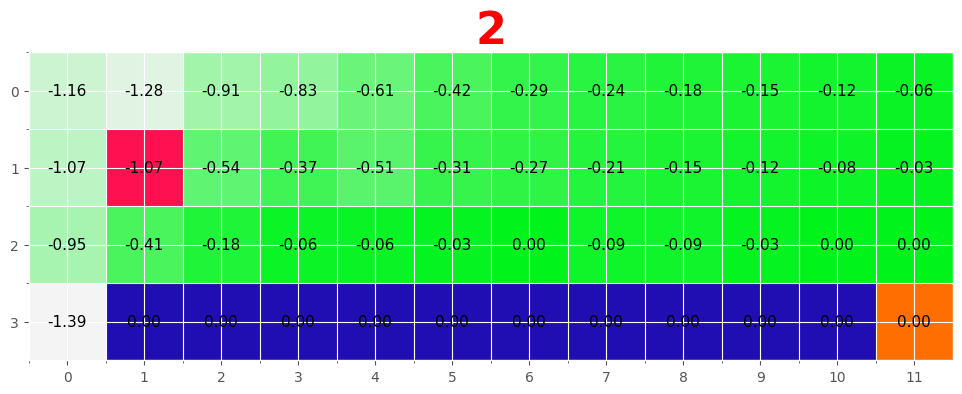

In [ ]:
n_experiments = 2000
n_episodes = 5000

rewards = np.zeros((n_experiments, n_episodes))

for experiment in trange(n_experiments):

    env = GridWorld(True)

    agent = SarsaNstepsCliffAgent(alpha=0.01, 
                                  gamma=0.99, 
                                  epsilon=0.01, 
                                  environment=env,
                                  seed=experiment,
                                  n_steps=3)
    for episode in range(n_episodes):
        rewards[experiment][episode] = generate_episode(env, agent, show=True)

agent3StepsSarsareward = rewards.mean(0).copy()

In [ ]:
dump(agent3StepsSarsareward, save_path + 'agent3StepsSarsareward.pkl')

['/content/drive/MyDrive/results_cliffworld/agent3StepsSarsareward.pkl']

In [ ]:
n_experiments = 2000
n_episodes = 5000

rewards = np.zeros((n_experiments, n_episodes))

for experiment in trange(n_experiments):

    env = GridWorld(False)

    agent = SarsaNstepsCliffAgent(alpha=0.01, 
                                  gamma=0.99, 
                                  epsilon=0.01, 
                                  environment=env,
                                  seed=experiment,
                                  n_steps=1)
    for episode in range(n_episodes):
        rewards[experiment][episode] = generate_episode(env, agent, show=False)
      
agent1StepsSarsareward = rewards.mean(0).copy()

100%|██████████| 2000/2000 [3:37:13<00:00,  6.52s/it]


In [ ]:
dump(agent1StepsSarsareward, save_path + 'agent1StepsSarsareward.pkl')

['/content/drive/MyDrive/results_cliffworld/agent1StepsSarsareward.pkl']

In [ ]:
n_experiments = 2000
n_episodes = 5000

rewards = np.zeros((n_experiments, n_episodes))

for experiment in trange(n_experiments):

    env = GridWorld(False)

    agent = ExpectedSarsaNstepsCliffAgent(alpha=0.01, 
                                  gamma=0.99, 
                                  epsilon=0.01, 
                                  environment=env,
                                  seed=experiment,
                                  n_steps=3)
    for episode in range(n_episodes):
        rewards[experiment][episode] = generate_episode(env, agent, show=False)

agent3StepsExpectedSarsareward = rewards.mean(0).copy()

100%|██████████| 2000/2000 [5:06:31<00:00,  9.20s/it]


In [ ]:
dump(agent3StepsExpectedSarsareward, save_path + 'agent3StepsExpectedSarsareward.pkl')

['/content/drive/MyDrive/results_cliffworld/agent3StepsExpectedSarsareward.pkl']

In [ ]:
n_experiments = 2000
n_episodes = 5000

rewards = np.zeros((n_experiments, n_episodes))

for experiment in trange(n_experiments):

    env = GridWorld(False)

    agent = ExpectedSarsaNstepsCliffAgent(alpha=0.01, 
                                  gamma=0.99, 
                                  epsilon=0.01, 
                                  environment=env,
                                  seed=experiment,
                                  n_steps=1)
    for episode in range(n_episodes):
        rewards[experiment][episode] = generate_episode(env, agent, show=False)

agent1StepsExpectedSarsareward = rewards.mean(0).copy()

  8%|▊         | 151/2000 [27:31<4:51:16,  9.45s/it]

In [ ]:
dump(agent1StepsExpectedSarsareward, save_path + 'agent1StepsExpectedSarsareward.pkl')

In [ ]:
n_experiments = 2000
n_episodes = 5000

rewards = np.zeros((n_experiments, n_episodes))

for experiment in trange(n_experiments):

    env = GridWorld(True)

    agent = TDErrorNstepsCliffAgent(alpha=0.01, 
                                  gamma=0.99, 
                                  epsilon=0.01, 
                                  environment=env,
                                  seed=experiment,
                                  n_steps=2)
    for episode in range(n_episodes):
        rewards[experiment][episode] = generate_episodeTDError(env, agent, show=True)
      
agent1StepsTDErrorreward = rewards.mean(0).copy()

  0%|          | 0/2000 [16:27<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
dump(agent1StepsTDErrorreward, save_path + 'agent1StepsTDErrorreward.pkl')

In [ ]:
n_experiments = 2000
n_episodes = 5000

rewards = np.zeros((n_experiments, n_episodes))

for experiment in range(n_experiments):

    env = GridWorld(False)

    agent = TDErrorNstepsCliffAgent(alpha=0.01, 
                                  gamma=0.99, 
                                  epsilon=0.01, 
                                  environment=env,
                                  seed=experiment,
                                  n_steps=4)
    for episode in range(n_episodes):
        rewards[experiment][episode] = generate_episodeTDError(env, agent, show=False)
      
agent3StepsTDErrorreward = rewards.mean(0).copy()

In [ ]:
dump(agent3StepsTDErrorreward, save_path + 'agent3StepsTDErrorreward.pkl')

In [ ]:
n_experiments = 2000
n_episodes = 5000

rewards = np.zeros((n_experiments, n_episodes))

for experiment in trange(n_experiments):

    env = GridWorld(False)

    agent = OffPolicySarsaNstepsCliffAgent(alpha=0.01, 
                                  gamma=0.99, 
                                  epsilon=0.01, 
                                  environment=env,
                                  seed=experiment,
                                  n_steps=3)
    
    for episode in range(n_episodes):
        rewards[experiment][episode] = generate_episode_offpolicy(env, agent, show=False)

agent3StepsOffPolicySarsareward = rewards.mean(0).copy()

  0%|          | 2/2000 [01:09<19:19:11, 34.81s/it]

KeyboardInterrupt: ignored

In [ ]:
plt.rcParams["figure.figsize"] = (20,16)

plt.title('Cliff World')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(range(1, n_episodes + 1), agent1StepsSarsareward, 'b--',
         range(1, n_episodes + 1), agent3StepsSarsareward,'g', 
         range(1, n_episodes + 1), agent1StepsTDErrorreward,
         range(1, n_episodes + 1), agent3StepsTDErrorreward,
         range(1, n_episodes + 1), agent1StepsExpectedSarsareward,
         range(1, n_episodes + 1), agent3StepsExpectedSarsareward)

plt.legend(['One-step Sarsa',
            'Three-step Sarsa', 
            'One-step TD error', 
            'Three-step TD error',
            'One-step Expected Sarsa',
            'Three-step Expected Sarsa',], loc=2)

plt.savefig(save_path + 'results_cliffworld_5000episodes.png')
plt.show()

In [ ]:
# https://habr.com/ru/company/hsespb/blog/444428/
# https://github.com/lbarazza/Tile-Coding/blob/master/tiles.py